## Airline Passenger Satisfaction Prediction & Analysis

In [13]:
import pandas as pd
import numpy as np

We will be trying to predict and understand airline passenger satisfaction based on passenger surveys, demographics, and other useful information. Some possible issues with the data could result from the nature in the way that the survey data was collected. It relies on passengers to be honest and complete in their responses along with realizing that passengers who had a poor experience are more likely to leave a bad review than the average passenger.

## Load and Transform Data

In [14]:
# Load CSV files
df1 = pd.read_csv(r"C:\Users\broga\OneDrive\Desktop\MSBA\Adv_ML\Midterm\data1.csv")
df2 = pd.read_csv(r"C:\Users\broga\OneDrive\Desktop\MSBA\Adv_ML\Midterm\data2.csv")

# Concatenate the two DataFrames
full_df = pd.concat([df1, df2])

# Changing categorical variables to 'category' type
categorical_columns = ['Gender', 'Customer_Type', 'Travel_Type','Class','Inflight_Wifi','Time_Convenience',
                       'Online_Booking_Ease','Gate_Location','Food_Drink','Online_Boarding','Seat_Comfort',
                       'Entertainment','Service','Leg_Room','Baggage_Handling','CheckIn_service','Inflight_Service',
                       'Cleanliness','Satisfaction']
full_df[categorical_columns] = full_df[categorical_columns].astype('category')

# Changing necessary variables to float
float_columns = ['Flight_Distance','Departure_Delay','Arrival_Delay']
full_df[float_columns] = full_df[float_columns].astype(float)

# Dropping all rows with NA values
full_df = full_df.dropna()

#fulldf.dtypes
#full_df.info()
full_df.head()

,id,Gender,Customer_Type,Age,Travel_Type,Class,Flight_Distance,Inflight_Wifi,Time_Convenience,Online_Booking_Ease,...,Entertainment,Service,Leg_Room,Baggage_Handling,CheckIn_service,Inflight_Service,Cleanliness,Departure_Delay,Arrival_Delay,Satisfaction
0,19556,Female,Loyal Customer,52,Business travel,Eco,160.0,5,4,3,...,5,5,5,5,2,5,5,50.0,44.0,satisfied
1,90035,Female,Loyal Customer,36,Business travel,Business,2863.0,1,1,3,...,4,4,4,4,3,4,5,0.0,0.0,satisfied
2,12360,Male,disloyal Customer,20,Business travel,Eco,192.0,2,0,2,...,2,4,1,3,2,2,2,0.0,0.0,neutral or dissatisfied
3,77959,Male,Loyal Customer,44,Business travel,Business,3377.0,0,0,0,...,1,1,1,1,3,1,4,0.0,6.0,satisfied
4,36875,Female,Loyal Customer,49,Business travel,Eco,1182.0,2,3,4,...,2,2,2,2,4,2,4,0.0,20.0,satisfied


After concatenating the two files and converting necessary data types we can begin to explore our data further with some initial visualizations to better understand the relationship between our variables and customer satisfaction.


## Exploratory Data Analysis

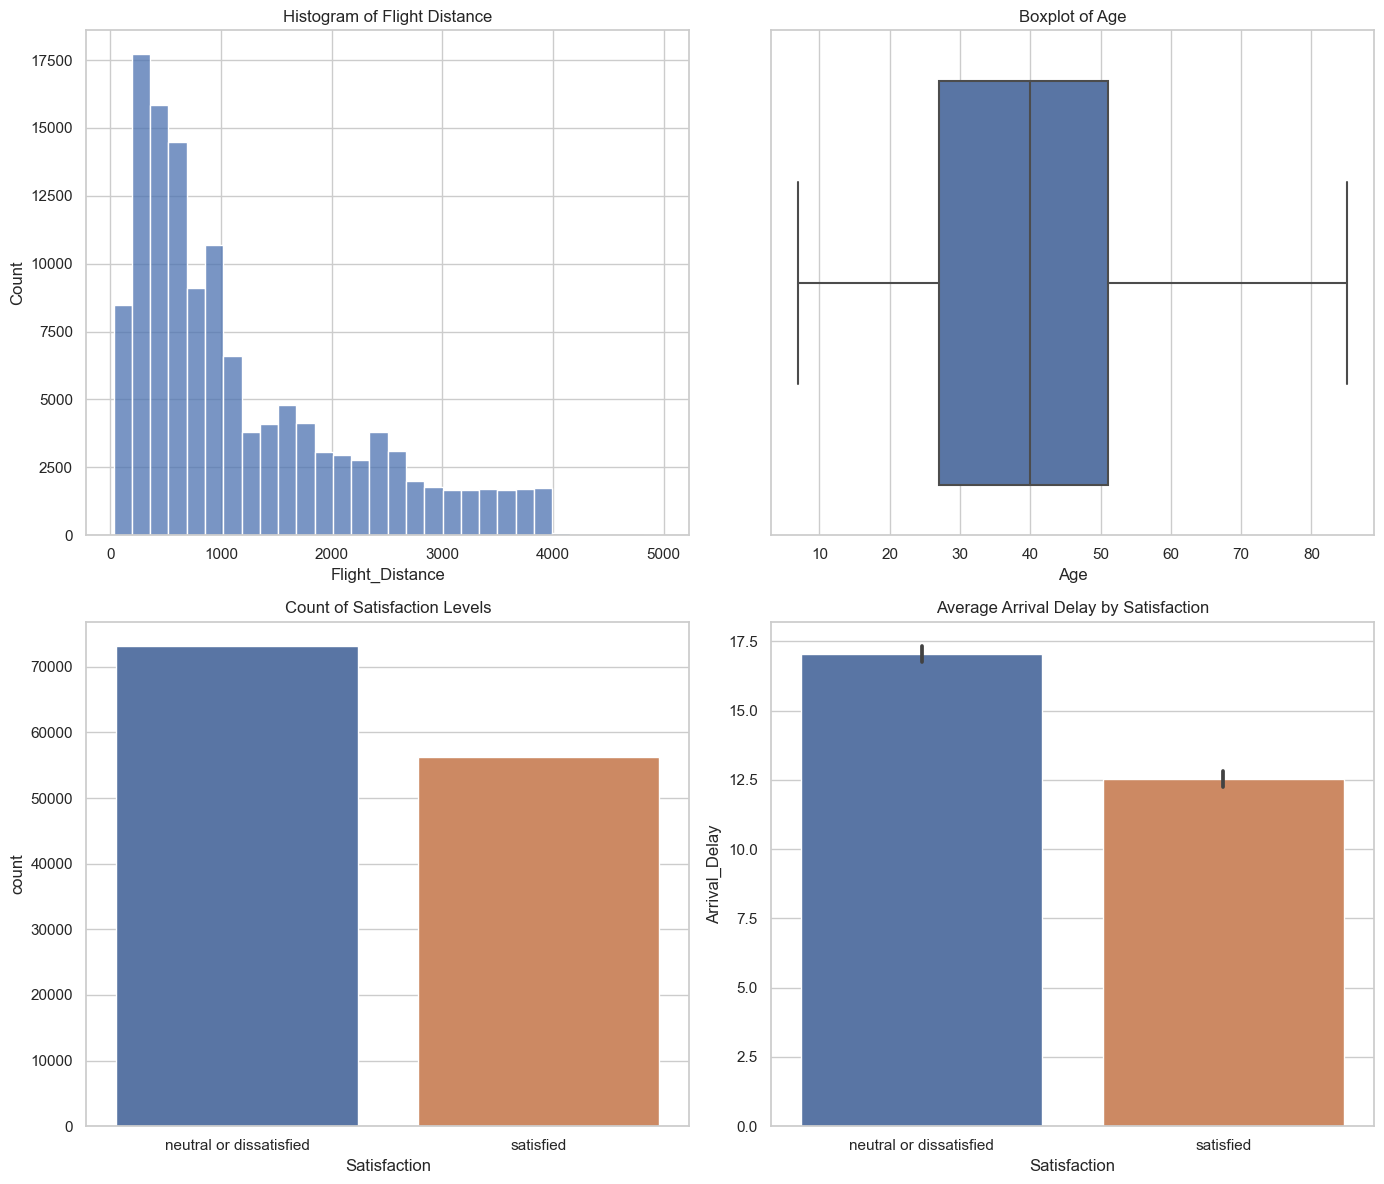

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Setting the aesthetic style of the plots
sns.set(style="whitegrid")

# Creating a figure with subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 12))

# Histogram of Flight Distance
sns.histplot(full_df['Flight_Distance'], bins=30, ax=axes[0, 0])
axes[0, 0].set_title('Histogram of Flight Distance')

# Boxplot of Age
sns.boxplot(x='Age', data=full_df, ax=axes[0, 1])
axes[0, 1].set_title('Boxplot of Age')

# Count plot of Satisfaction levels
sns.countplot(x='Satisfaction', data=full_df, ax=axes[1, 0])
axes[1, 0].set_title('Count of Satisfaction Levels')

# Bar plot of Average Arrival Delay by Satisfaction
sns.barplot(x='Satisfaction', y='Arrival_Delay', data=full_df, ax=axes[1, 1])
axes[1, 1].set_title('Average Arrival Delay by Satisfaction')

# Adjusting layout and showing the plot
plt.tight_layout()
plt.show()

Above are a few visualizations to help us better understand the data we are dealing with. The top left graph illustrates that we are dealing with flights that are < 1000 miles generally. This makes sense inutitively as most flights generally fall in that distance range. Our top right graph shows that most participants range from age 30-50 with a mean age of 40, which aligns with many adults who fly frequently (work-related). 

The bottom left graph shows that there is a slight imbalance in our target variable (Satisfaction). Due to this slight imbalance we include parameters in our modeling process below to account for the nature of our target variable. Additionally, the bottom right graph gives us an inital look into a potentially significant variable (Arrival Delay) and its relationship with our target variable. According to our data, it appears that a greater arrival delay results in a higher probability that a passenger is neutral or dissatisfied with their flight. We dive deeper into particular significant variables within our best model below.

## Predictive Modeling

In [16]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_selector
from sklearn.preprocessing import LabelEncoder

# Convert categorical labels to numeric for XGBoost
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(full_df['Satisfaction'])

X = full_df.drop(['Satisfaction','id'], axis=1)
y = y_encoded

ct = ColumnTransformer(
    [
        ("dummify", OneHotEncoder(sparse_output=False, handle_unknown='ignore'),
         make_column_selector(dtype_include=['category','object'])), 
        ("standardize", StandardScaler(), make_column_selector(dtype_include=np.number))
    ],
    remainder="passthrough"
)

### Naive Bayes

In [17]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, accuracy_score, f1_score, roc_auc_score

#class prior to deal with imbalance in data
nb_class_prior = [0.56,0.44]

nb_pipeline = Pipeline([
    ("preprocessing", ct),  
    ("naive_bayes", BernoulliNB(class_prior=nb_class_prior))
])

# Define parameter grid
param_grid = {
    "naive_bayes__alpha": [0.5, 1.0],  
}

# Setup GridSearchCV with metrics that are informative for imbalanced datasets
grid_search = GridSearchCV(nb_pipeline, param_grid, cv=5, 
                           scoring={'Accuracy': make_scorer(accuracy_score), 
                                    'F1': make_scorer(f1_score),
                                    'ROC_AUC': make_scorer(roc_auc_score, needs_threshold=True)}, 
                           refit='ROC_AUC',  
                           verbose=1)

# Fit the model
grid_search.fit(X, y)  

print("Best parameters:", grid_search.best_params_)

# Display the best scores
best_accuracy = round(grid_search.cv_results_['mean_test_Accuracy'][grid_search.best_index_], 4)
best_f1 = round(grid_search.cv_results_['mean_test_F1'][grid_search.best_index_], 4)
best_roc_auc = round(grid_search.cv_results_['mean_test_ROC_AUC'][grid_search.best_index_], 4)

print(f"Best BernoulliNB Model Accuracy: {best_accuracy}")
print(f"Best BernoulliNB Model F1 Score: {best_f1}")
print(f"Best BernoulliNB Model ROC AUC Score: {best_roc_auc}")

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best parameters: {'naive_bayes__alpha': 0.5}
Best BernoulliNB Model Accuracy: 0.8979
Best BernoulliNB Model F1 Score: 0.8819
Best BernoulliNB Model ROC AUC Score: 0.9564


I decided to begin with a Bernouill (Binary Classfication) Naive Bayes for an initial baseline for model metrics. The Bernoulli NB model is easy to setup and serves as an efficient way to begin judging model metrics. The nb_class_prior parameter is included to account for the imbalanced target class.

### Random Forest Classifier

In [20]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, accuracy_score, f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier

# Pipeline setup with Random Forest classifier
rf_pipeline = Pipeline([
    ("preprocessing", ct),  
    ("random_forest", RandomForestClassifier(class_weight = 'balanced', random_state=1))
])

# Define a simple parameter grid for Random Forest
param_grid = {
    "random_forest__max_depth": [8,10],  
    "random_forest__min_samples_leaf": [6,8],
    "random_forest__n_estimators": [100,150]
}

# Setup GridSearchCV with metrics that are informative for imbalanced datasets
grid_search = GridSearchCV(rf_pipeline, param_grid, cv=5, 
                           scoring={'Accuracy': make_scorer(accuracy_score), 
                                    'F1': make_scorer(f1_score),
                                    'ROC_AUC': make_scorer(roc_auc_score, needs_threshold=True)}, 
                           refit='ROC_AUC',  
                           verbose=1)

# Fit the model
grid_search.fit(X, y)

print("Best parameters:", grid_search.best_params_)

# Display the best scores
best_accuracy = round(grid_search.cv_results_['mean_test_Accuracy'][grid_search.best_index_], 4)
best_f1 = round(grid_search.cv_results_['mean_test_F1'][grid_search.best_index_], 4)
best_roc_auc = round(grid_search.cv_results_['mean_test_ROC_AUC'][grid_search.best_index_], 4)

print(f"Best Random Forest Model Accuracy: {best_accuracy}")
print(f"Best Random Forest Model F1 Score: {best_f1}")
print(f"Best Random Forest Model ROC AUC Score: {best_roc_auc}")


Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters: {'random_forest__max_depth': 10, 'random_forest__min_samples_leaf': 6, 'random_forest__n_estimators': 150}
Best Random Forest Model Accuracy: 0.9422
Best Random Forest Model F1 Score: 0.9335
Best Random Forest Model ROC AUC Score: 0.988


Our Random Forest Classifier model outperformed the Bernoulli NB model but lost out to the XGBoost model. This type of performance is typical in these prediction challenges where Random Forests perform well, but not as well as XGBoost models.

### XGBoost

In [18]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, accuracy_score, f1_score, roc_auc_score
from xgboost import XGBClassifier

xgb_scale_pos_weight = sum(y == 0) / sum(y == 1)

# Pipeline setup with XGBoost classifier
xgb_pipeline = Pipeline([
    ("preprocessing", ct),  
    ("xgboost", XGBClassifier(use_label_encoder=False, eval_metric='logloss',scale_pos_weight = xgb_scale_pos_weight, random_state=1))
])

# Define a simple parameter grid for XGBoost
param_grid = {
    "xgboost__max_depth": [8,10,12],  
    "xgboost__min_child_weight": [2,6,8],
    "xgboost__learning_rate": [0.05, 0.1],
    "xgboost__n_estimators": [100,200,250]
}

# Setup GridSearchCV with metrics that are informative for imbalanced datasets
grid_search = GridSearchCV(xgb_pipeline, param_grid, cv=5, 
                           scoring={'Accuracy': make_scorer(accuracy_score), 
                                    'F1': make_scorer(f1_score),
                                    'ROC_AUC': make_scorer(roc_auc_score, needs_threshold=True)}, 
                           refit='ROC_AUC',  
                           verbose=1)

# Fit the model
grid_search.fit(X, y)

print("Best parameters:", grid_search.best_params_)

# Display the best scores
best_accuracy = round(grid_search.cv_results_['mean_test_Accuracy'][grid_search.best_index_], 4)
best_f1 = round(grid_search.cv_results_['mean_test_F1'][grid_search.best_index_], 4)
best_roc_auc = round(grid_search.cv_results_['mean_test_ROC_AUC'][grid_search.best_index_], 4)

print(f"Best XGBoost Model Accuracy: {best_accuracy}")
print(f"Best XGBoost Model F1 Score: {best_f1}")
print(f"Best XGBoost Model ROC AUC Score: {best_roc_auc}")

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best parameters: {'xgboost__learning_rate': 0.1, 'xgboost__max_depth': 8, 'xgboost__min_child_weight': 2, 'xgboost__n_estimators': 250}
Best XGBoost Model Accuracy: 0.9642
Best XGBoost Model F1 Score: 0.9584
Best XGBoost Model ROC AUC Score: 0.9955


The XGBoost model above out performed the best out of all models with very high scores in each metric. The scale_pos_weight parameter is included to account for the target variable imbalance. The XGBoost model commonly performs very well under prediction scenarios.

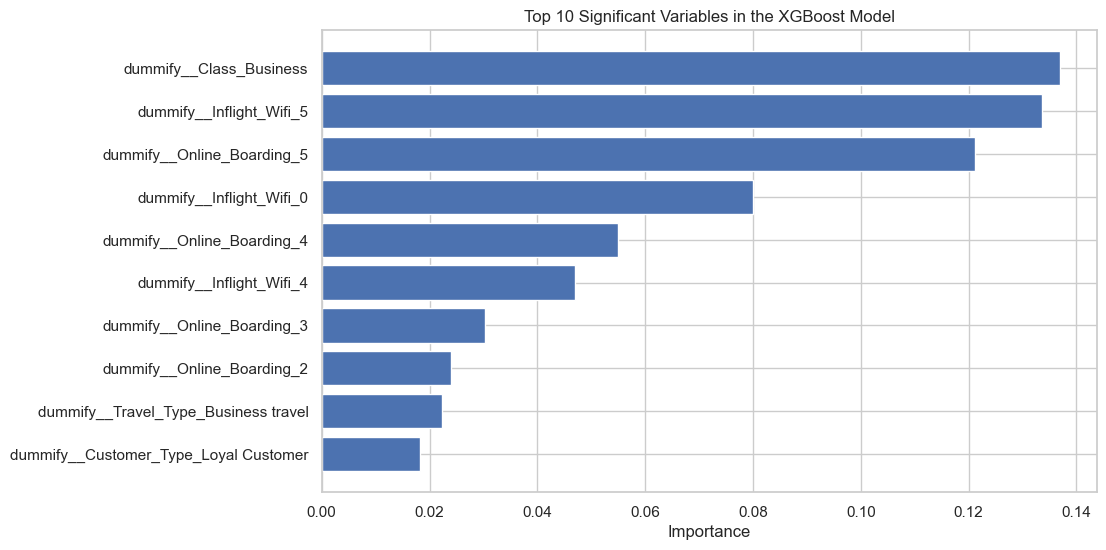

In [26]:
import matplotlib.pyplot as plt

# Best Pipeline setup with XGBoost classifier
best_xgb_pipeline = Pipeline([
    ("preprocessing", ct),  
    ("xgboost", XGBClassifier(learning_rate =0.1, max_depth=8, min_child_weight = 2, n_estimators = 250, use_label_encoder=False, eval_metric='logloss',scale_pos_weight = xgb_scale_pos_weight, random_state=1))
])

#Fit model 
xgb_model = best_xgb_pipeline.fit(X,y)

# Access the XGBoost classifier from the pipeline
xgb_classifier = xgb_model.named_steps['xgboost']

# Get feature importances from the XGBoost classifier
feature_importances = xgb_classifier.feature_importances_

# Get the feature names from the column transformer
feature_names = best_xgb_pipeline.named_steps['preprocessing'].get_feature_names_out()

# Combine feature names and their importances
features_importance = zip(feature_names, feature_importances)

# Sort the features by importance
sorted_features = sorted(features_importance, key=lambda x: x[1], reverse=True)

# Select the top 10 most important features
top_10_features = sorted_features[:10]

# Separate the feature names and their importances for plotting
feature_names, importances = zip(*top_10_features)

# Create the bar graph
plt.figure(figsize=(10, 6))
plt.barh(feature_names, importances)
plt.xlabel('Importance')
plt.title('Top 10 Significant Variables in the XGBoost Model')
plt.gca().invert_yaxis()  
plt.show()

## Airline Recommendations

In our best performing XGBoost model, it appears that the passengers class, quality of inflight wifi, and online boarding experience were the most significant variables. This will help determine our recommendations to the airline below.

1. Provide noticeable upgrades to the Business class passengers, without simultaneously causing the economy class to suffer :

The most significant variable from our model was the passenger belonging to the Business class, which is the most expensive ticket class available. This indicates that Business class passengers offer more significant feedback compared to other classes. This is most likley related to the fact that they pay higher prices for their seats so they are incentivized to have a stronger opinion. Therefore, airlines should offer amenities and an experience that justifies the increased price, without sacrificing the experience of economy class passengers. Only focusing on the Business class, will cause the same issues to become prevalent in the economy class, which occupies even more passengers. 

2. Offer a stable and high speed internet connection for all passengers:

Every level of wifi satisfaction was present on the most significant variables list which highlights its significance to all passengers in todays technological world. Airlines should prioritize offering wifi to everybody, and not only offering to the Business class for the reasons mentioned above. 

3. Invest to improve/create a streamlined online boarding experience:

Similar to the wifi, almost every tier of the online boarding variable was present in our list of most significant variables. Since it is a clear significant factor that determines a given passengers satisfaction, resources should be invested to create and maintain a fool-proof boarding experience for all. Whether this entails creating and maintaing an application/website, it is necessary to retain and gain satisfied passengers, thus increasing revenue and airline reputation. 